In [17]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [18]:
cleansed=load_amihud_markets_price()

In [19]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [20]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

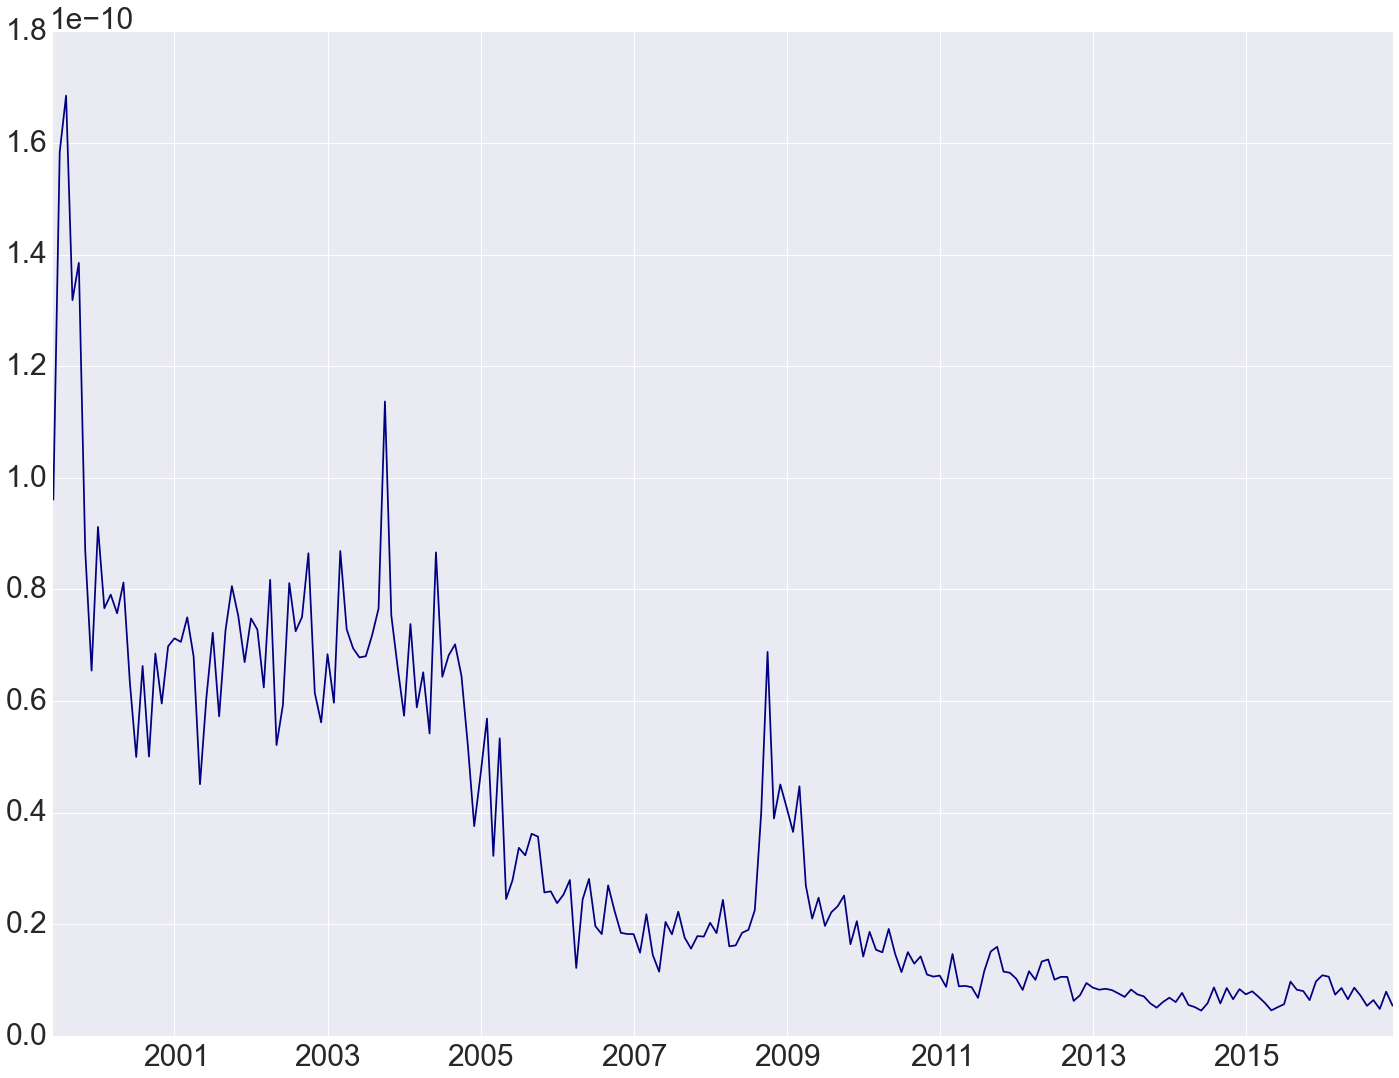

In [21]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


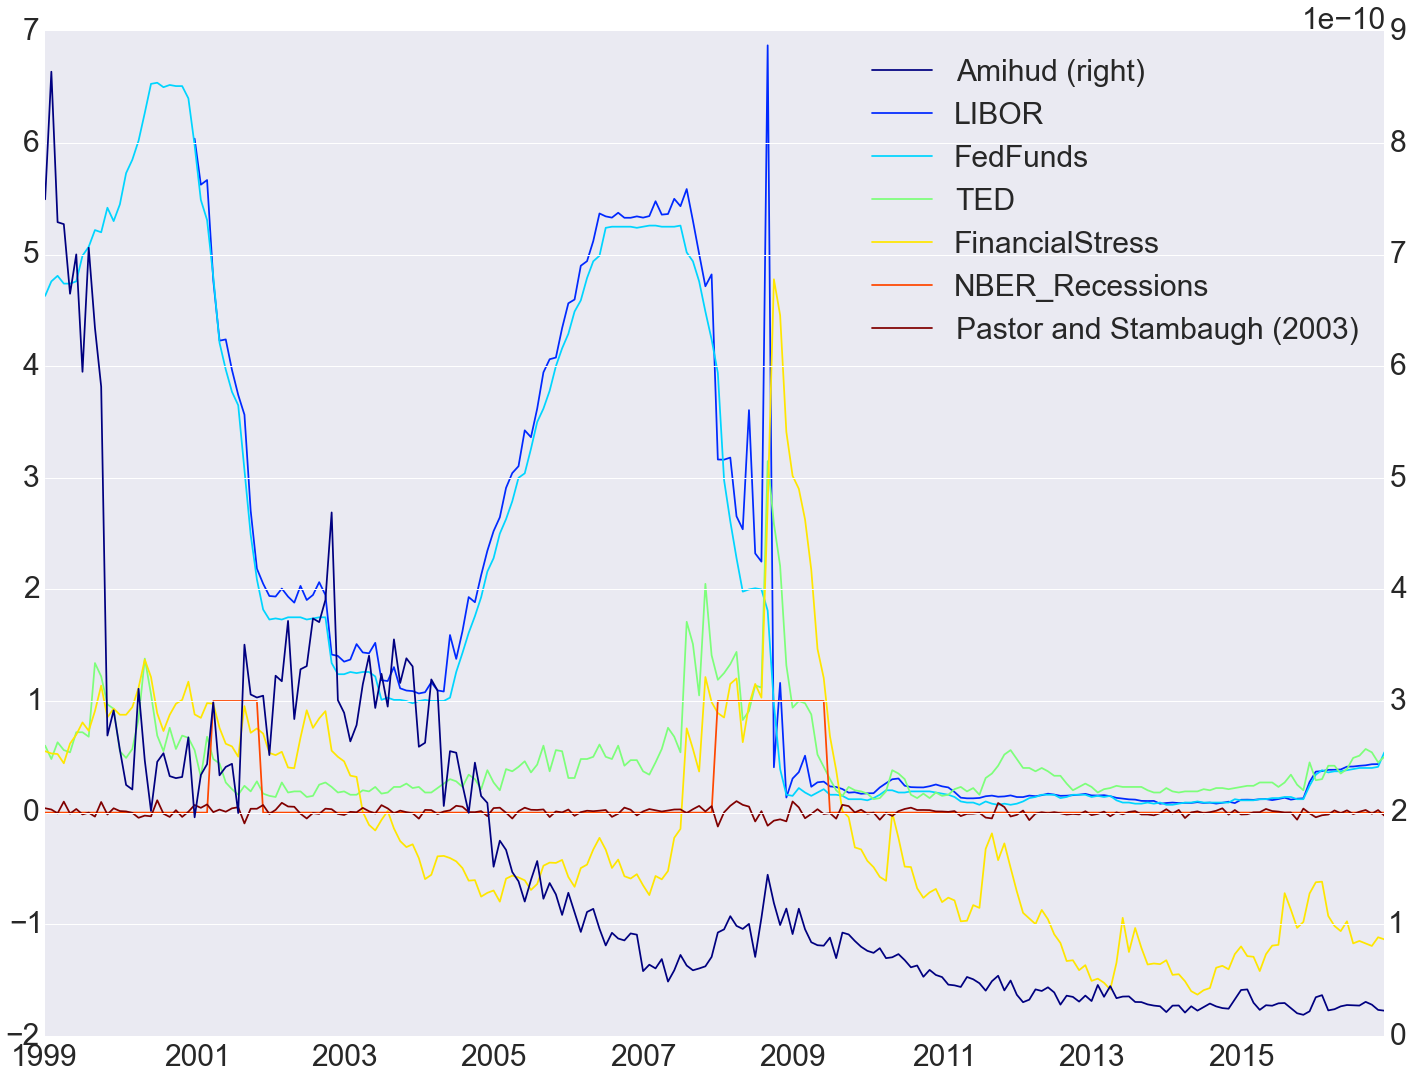

In [22]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
df=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
df['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']


# Further undersanding liquidity factor

The further paper is trying to understand why do less liquid markets create this factor.  

The other state variables:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions



Trying to understand in the overall median market liquidity and see if some market state varaibles explain it:

$$ MKTILLIQ_i = \alpha_0 + \beta_1 LIBOR_t + \beta_2 TED_t + \beta_3 FinancialStress_t + \beta_4 NBER_Recessions_t + \epsilon_t $$

Where $MKTILLIQ_i$ is the median monthly value of market illiquidity trhough time based on Amihud (2002) illiquidity of my universe of global futures contracts.  $LIBOR_t$ and Treasury over Eurodollar ($TED_t$) spreads is the month end figures.  $FinancialStress_t$ is XXXX. Lastly $NBER_Recessions_t$ is the ressionary periods classified ex-post by NBER.

In [23]:
data=df.dropna()
data['Intercept']=1

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [34]:
data.Amihud=amihud.median(axis=1).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


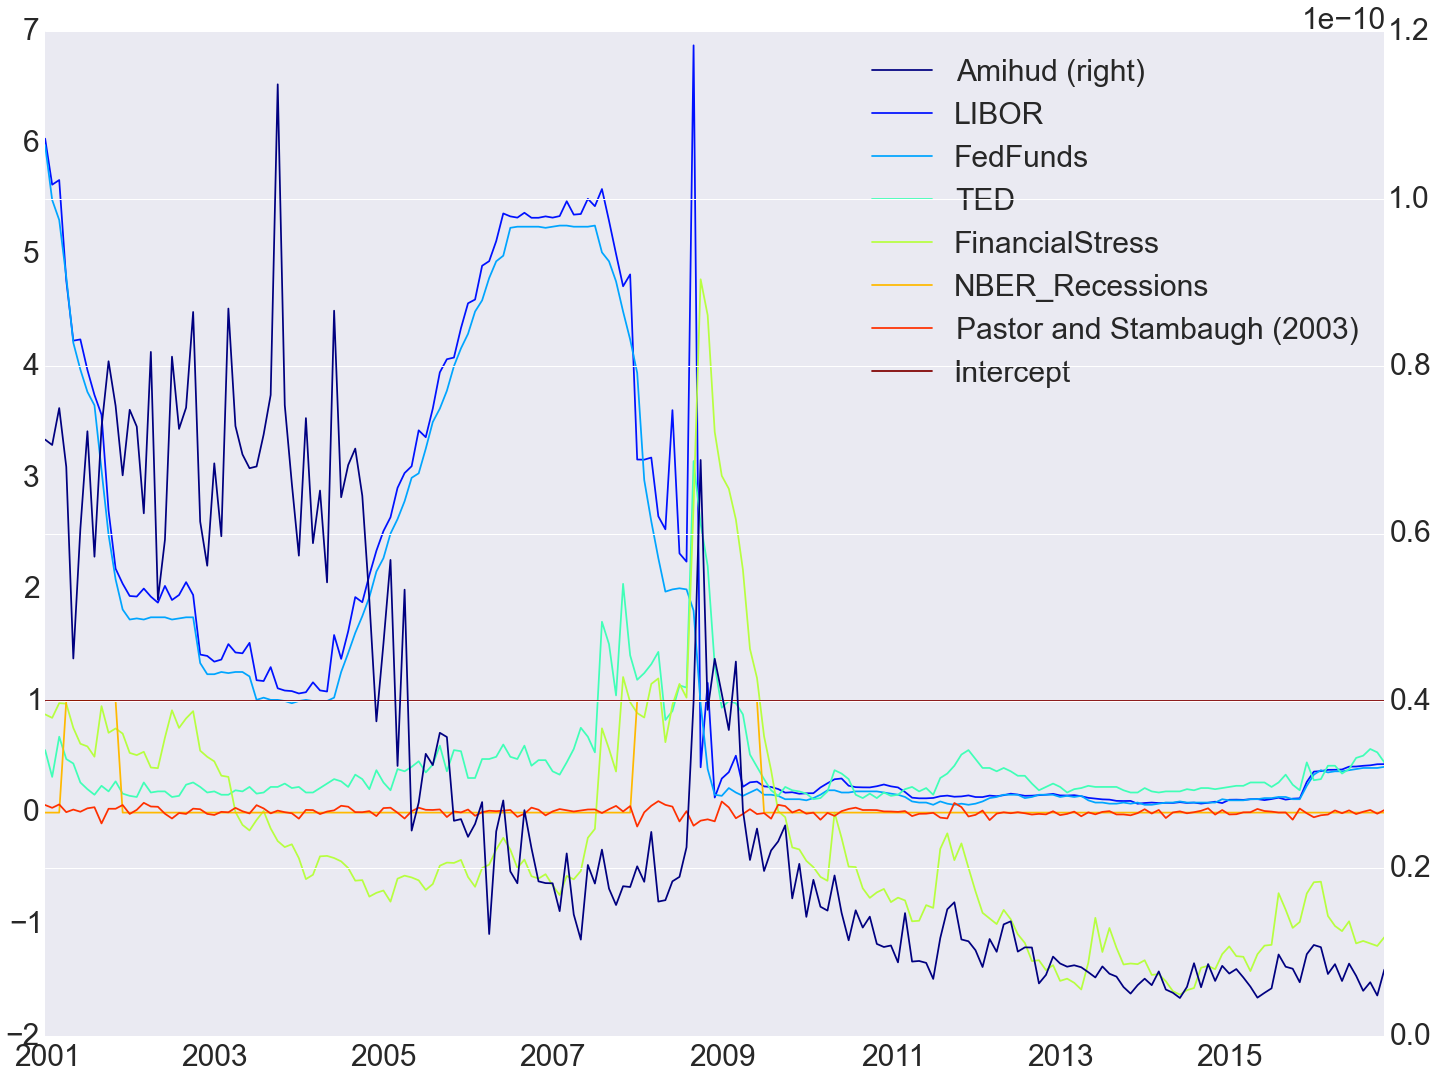

In [36]:
data.plot(colormap='jet',secondary_y='Amihud')

In [37]:
col=['LIBOR', 'TED', 'FinancialStress','NBER_Recessions','Pastor and Stambaugh (2003)']
dd=[]
tt=[]
r2=[]
for i in range(0,5,1):
    reg=['Intercept']
    d=[0]*int(len(col)+1)
    t=[0]*int(len(col)+1)
    reg.append(col[i])
    res=sm.OLS(data.Amihud,data[reg]).fit()
    d[0]=res.params.Intercept
    d[i+1]=res.params[col[i]]
    t[0]=res.tvalues.Intercept
    t[i+1]=res.tvalues[col[i]]
    r2.append(res.rsquared_adj)
    tt.append(t)
    dd.append(d)
d=[0]*int(len(col)+1)
t=[0]*int(len(col)+1)
col.append('Intercept')
res=sm.OLS(data.Amihud,data[col]).fit()
d[0]=res.params.Intercept
t[0]=res.tvalues.Intercept
r2.append(res.rsquared_adj)
i=1
for c in col[:-1]: 
    d[i]=res.params[c] 
    t[i]=res.tvalues[c]
    i=i+1
tt.append(t)
dd.append(d)

Note every coefifient is mutliplied 10e10 given the nature of the model.

In [38]:
pd.DataFrame(r2,columns=['Adjusted R^2']).T

,0,1,2,3,4,5
Adjusted R^2,0.076056,-0.004413,0.235336,0.028457,0.013156,0.5505


In [39]:
ind=col[-1:]+col[:-1]
x=(pd.DataFrame(dd,columns=ind)*1e11).round(2)
x['Adjusted R^2']=pd.Series(r2)
x.T.round(2)

,0,1,2,3,4,5
Intercept,2.31,3.03,3.26,2.77,2.90,4.97
LIBOR,0.38,0.00,0.00,0.00,0.00,0.39
TED,0.00,-0.18,0.00,0.00,0.00,-4.26
FinancialStress,0.00,0.00,1.17,0.00,0.00,2.44
NBER_Recessions,0.00,0.00,0.00,1.36,0.00,-1.60
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,9.47,-0.68
Adjusted R^2,0.08,-0.00,0.24,0.03,0.01,0.55


In [40]:
pd.DataFrame(tt,columns=ind).round(2).T

,0,1,2,3,4,5
Intercept,9.72,11.51,19.54,14.09,15.55,18.89
LIBOR,4.08,0.00,0.00,0.00,0.00,5.27
TED,0.00,-0.41,0.00,0.00,0.00,-10.11
FinancialStress,0.00,0.00,7.71,0.00,0.00,12.90
NBER_Recessions,0.00,0.00,0.00,2.56,0.00,-3.10
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,1.88,-0.19


In [41]:
ind2=[]
for col in ind:
    ind2.append(col+' Tstat')
tstat=pd.DataFrame(tt,columns=ind2).round(2)

In [42]:
full=tstat.join(x)

In [43]:
print full.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &     0 &      1 &      2 &      3 &      4 &      5 \\
\midrule
Intercept Tstat                   &  9.72 &  11.51 &  19.54 &  14.09 &  15.55 &  18.89 \\
LIBOR Tstat                       &  4.08 &   0.00 &   0.00 &   0.00 &   0.00 &   5.27 \\
TED Tstat                         &  0.00 &  -0.41 &   0.00 &   0.00 &   0.00 & -10.11 \\
FinancialStress Tstat             &  0.00 &   0.00 &   7.71 &   0.00 &   0.00 &  12.90 \\
NBER\_Recessions Tstat             &  0.00 &   0.00 &   0.00 &   2.56 &   0.00 &  -3.10 \\
Pastor and Stambaugh (2003) Tstat &  0.00 &   0.00 &   0.00 &   0.00 &   1.88 &  -0.19 \\
Intercept                         &  2.31 &   3.03 &   3.26 &   2.77 &   2.90 &   4.97 \\
LIBOR                             &  0.38 &   0.00 &   0.00 &   0.00 &   0.00 &   0.39 \\
TED                               &  0.00 &  -0.18 &   0.00 &   0.00 &   0.00 &  -4.26 \\
FinancialStress                   &  0.00 &   0.00 &   1.17 &   0.00 &   0.00 &   2.44 

#  Table ideas

For one panel I should run correlation matrix on monthly data to see if these are explaining the same thing.  

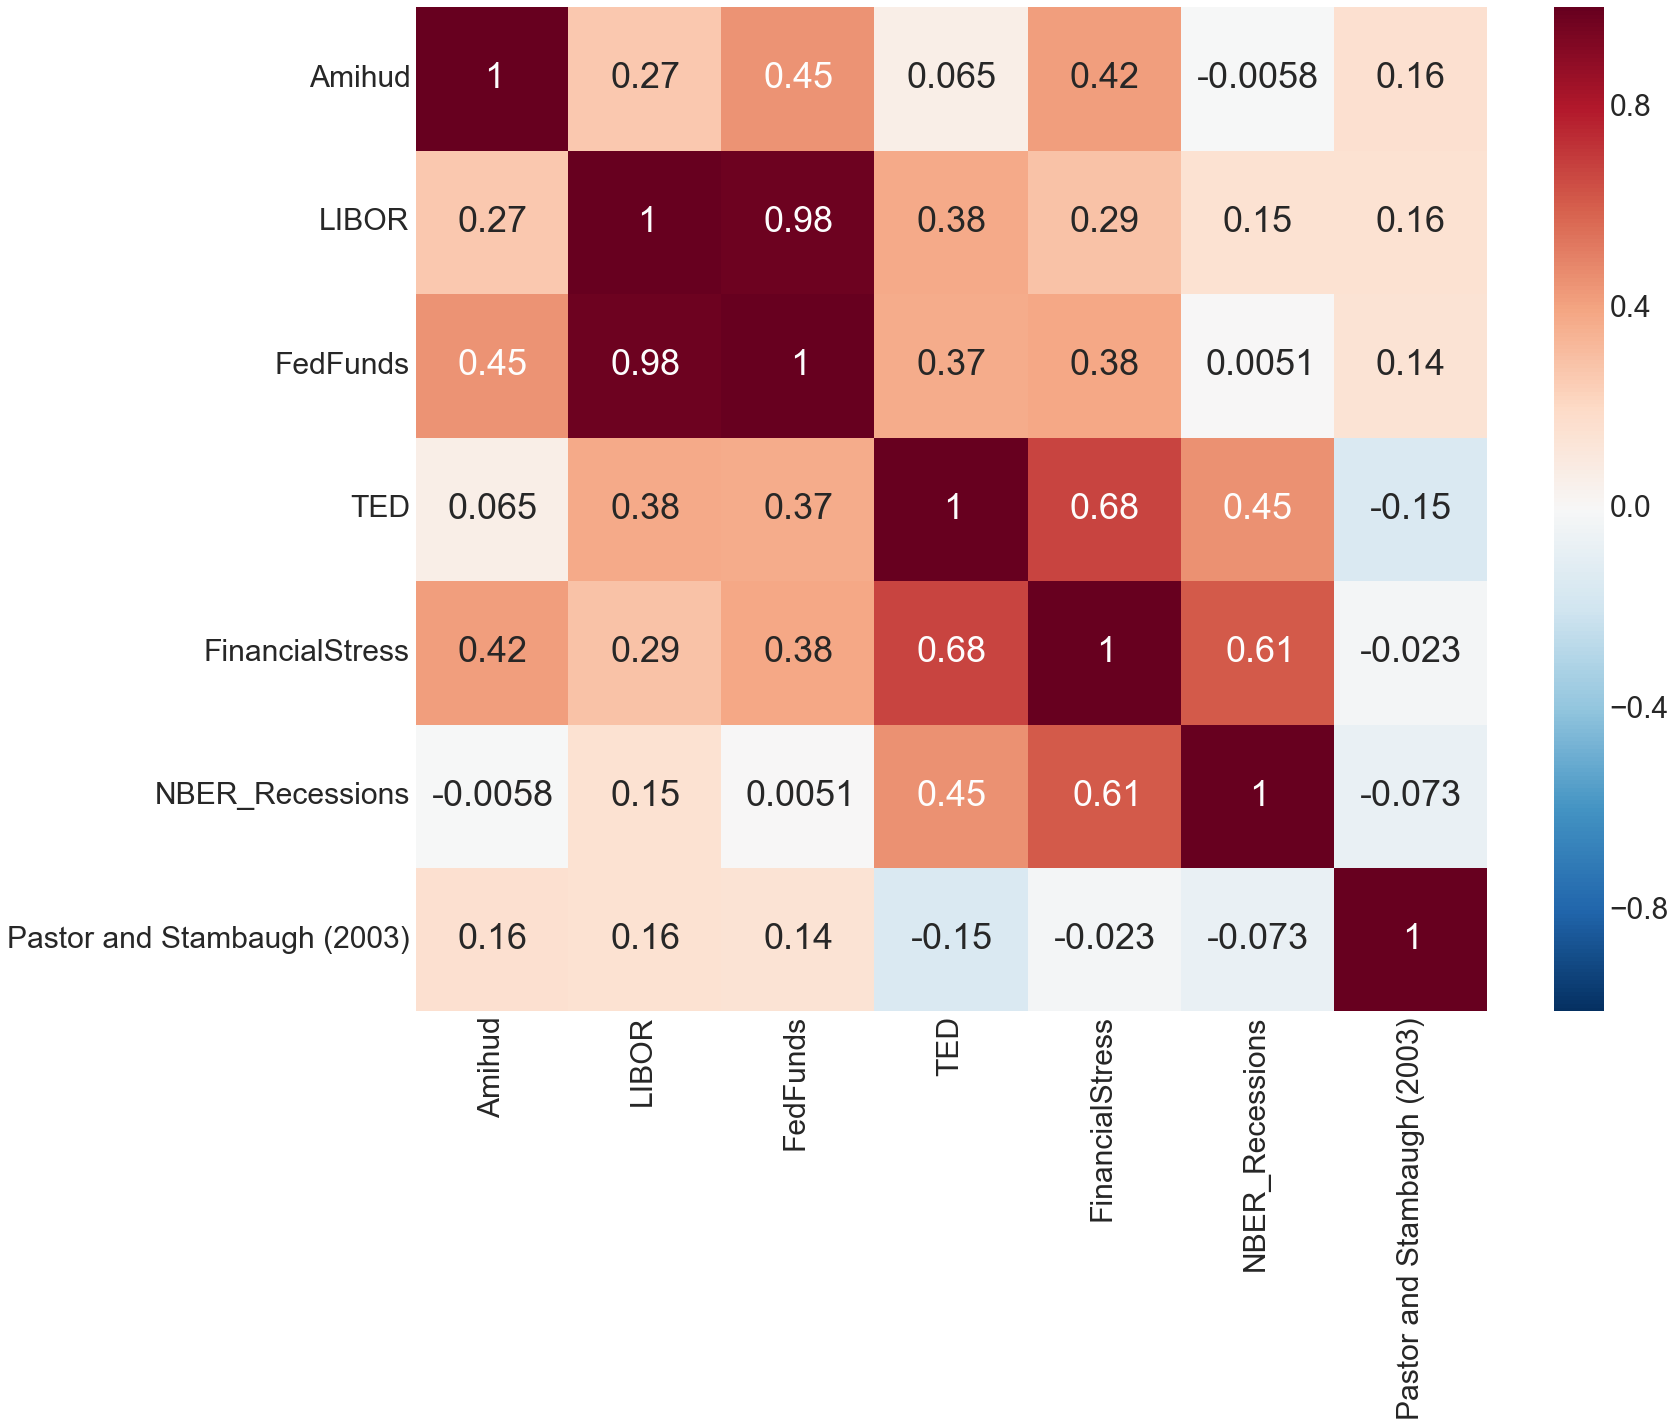

In [32]:
sns.heatmap(df.corr(),annot=True)